## Importation des bibliothèques

In [145]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


## Chargement des données, de notre dataset

In [148]:

file_path = "D:\\MEMO\\dataset\\statlog+shuttle\\shuttle.tst"
data = pd.read_csv(file_path, delim_whitespace=True, header=None, engine='python')

C:\Users\elton\AppData\Local\Temp\ipykernel_28880\3390801783.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None, engine='python')


## Exploration des données

In [151]:
data

,0,1,2,3,4,5,6,7,8,9
0,55,0,81,0,-6,11,25,88,64,4
1,56,0,96,0,52,-4,40,44,4,4
2,50,-1,89,-7,50,0,39,40,2,1
3,53,9,79,0,42,-2,25,37,12,4
4,55,2,82,0,54,-6,26,28,2,1
...,...,...,...,...,...,...,...,...,...,...
14495,80,0,84,0,-36,-29,4,120,116,5
14496,55,0,81,0,-20,25,26,102,76,4
14497,55,0,77,0,12,-22,22,65,42,4
14498,37,0,103,0,18,-16,66,85,20,1


In [153]:
data.shape

(14500, 10)

In [155]:
data.dtypes

0    int64
1    int64
2    int64
3    int64
4    int64
5    int64
6    int64
7    int64
8    int64
9    int64
dtype: object

In [157]:
print(data.columns)

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')


## Binarisation de la cible 


In [160]:
# Séparation des caractéristiques et de la cible
X = data.iloc[:, :-1]  # Colonnes 0 à 8
y = data.iloc[:, -1]   # Colonne 9

In [162]:
# Binarisation de la cible : classe 1 (normale) = 0, autres classes (anomalies) = 1
y_binary = (y != 1).astype(int)


In [164]:
# Standardisation des caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [166]:
# Séparation en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

In [168]:
# Modèle Isolation Forest
isolation_forest = IsolationForest(random_state=42, contamination=y_train.mean())
isolation_forest.fit(X_train)

IsolationForest(contamination=0.20844827586206896, random_state=42)

In [170]:
# Prédictions : -1 pour anomalies, 1 pour normales (convertir en binaire)
y_pred_train = (isolation_forest.predict(X_train) == -1).astype(int)
y_pred_test = (isolation_forest.predict(X_test) == -1).astype(int)

Rapport de classification pour Isolation Forest:

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      2296
           1       0.53      0.52      0.53       604

    accuracy                           0.80      2900
   macro avg       0.70      0.70      0.70      2900
weighted avg       0.80      0.80      0.80      2900



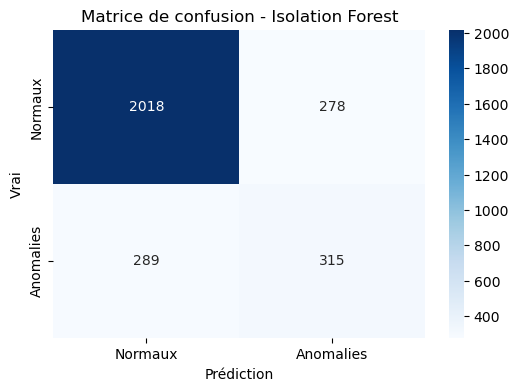

Metrics: {'Precision': 0.5311973018549747, 'Recall': 0.5215231788079471, 'F1-Score': 0.5263157894736842, 'Accuracy': 0.8044827586206896}


In [172]:
# Fonction d'évaluation des modèles
def evaluate_model(y_true, y_pred, model_name):
    print(f"Rapport de classification pour {model_name}:\n")
    print(classification_report(y_true, y_pred))

 # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["Normaux", "Anomalies"],
        yticklabels=["Normaux", "Anomalies"]
    )
    plt.title(f"Matrice de confusion - {model_name}")
    plt.xlabel("Prédiction")
    plt.ylabel("Vrai")
    plt.show()
    
    # Précision, rappel, F1-score
    metrics = classification_report(y_true, y_pred, output_dict=True)
    return {
        "Precision": metrics["1"]["precision"],
        "Recall": metrics["1"]["recall"],
        "F1-Score": metrics["1"]["f1-score"],
        "Accuracy": metrics["accuracy"]
    }

# Évaluation sur les données de test
metrics = evaluate_model(y_test, y_pred_test, "Isolation Forest")
print("Metrics:", metrics)

In [71]:
# PCA robuste
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [73]:
# Reconstruire les données après PCA
X_train_reconstructed = pca.inverse_transform(X_train_pca)
X_test_reconstructed = pca.inverse_transform(X_test_pca)

In [75]:
# Calcul des erreurs de reconstruction (distance euclidienne)
train_reconstruction_error = np.linalg.norm(X_train - X_train_reconstructed, axis=1)
test_reconstruction_error = np.linalg.norm(X_test - X_test_reconstructed, axis=1)

In [79]:
# Définir un seuil basé sur les erreurs de reconstruction
threshold = np.percentile(train_reconstruction_error, 95)


In [81]:
# Prédictions
y_pred_train_pca = (train_reconstruction_error > threshold).astype(int)
y_pred_test_pca = (test_reconstruction_error > threshold).astype(int)


Rapport de classification pour PCA Robuste:

              precision    recall  f1-score   support

           0       0.80      0.96      0.87      2296
           1       0.36      0.09      0.14       604

    accuracy                           0.78      2900
   macro avg       0.58      0.52      0.51      2900
weighted avg       0.71      0.78      0.72      2900



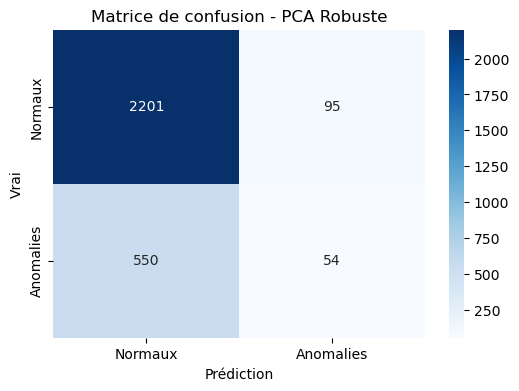

Metrics PCA: {'Precision': 0.3624161073825503, 'Recall': 0.08940397350993377, 'F1-Score': 0.14342629482071714, 'Accuracy': 0.7775862068965518}


In [83]:
# Évaluation du modèle PCA
metrics_pca = evaluate_model(y_test, y_pred_test_pca, "PCA Robuste")
print("Metrics PCA:", metrics_pca)

In [85]:
# Modèle LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=y_train.mean(), novelty=True)
lof.fit(X_train)


LocalOutlierFactor(contamination=0.20844827586206896, novelty=True)

In [87]:
# Prédictions : -1 pour anomalies, 1 pour normales (convertir en binaire)
y_pred_train_lof = (lof.predict(X_train) == -1).astype(int)
y_pred_test_lof = (lof.predict(X_test) == -1).astype(int)


Rapport de classification pour Local Outlier Factor:

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      2296
           1       0.23      0.25      0.24       604

    accuracy                           0.68      2900
   macro avg       0.52      0.52      0.52      2900
weighted avg       0.68      0.68      0.68      2900



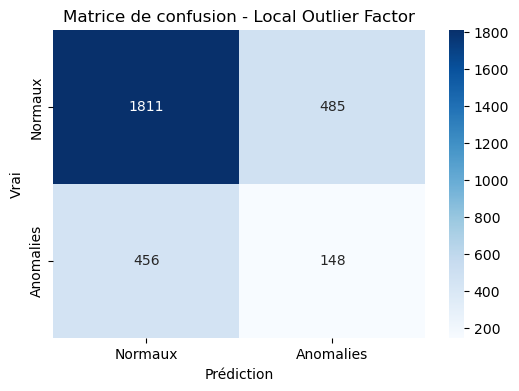

Metrics LOF: {'Precision': 0.23380726698262244, 'Recall': 0.24503311258278146, 'F1-Score': 0.2392886014551334, 'Accuracy': 0.6755172413793104}


In [89]:
# Évaluation du modèle LOF
metrics_lof = evaluate_model(y_test, y_pred_test_lof, "Local Outlier Factor")
print("Metrics LOF:", metrics_lof)